In [62]:
import torch
import torch.nn
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Digital filter design using ML

In [63]:
max_freq = 2000
cutoff_low = 300
cutoff_high = 700
filter_order = 45

In [64]:
t = torch.linspace(0, 2*torch.pi, max_freq*2)[None, None, ...]

hamming_window = 0.53836 + 0.46164*torch.cos(torch.linspace(-torch.pi, torch.pi, max_freq*2))[None,None,:]

In [76]:
def get_seq(t, freq, phase):    
    return torch.sin(freq*(t + phase))

def build_batch(t, batch_size):
    ii=[]
    oo=[]
    for i in range(batch_size):
        freq = torch.rand(1)*max_freq
        phase = torch.rand(1)*torch.pi
        s = get_seq(t, freq, phase)
        ii.append(s)
        if freq>cutoff_low and freq<cutoff_high:
            oo.append(s)
        else:
            oo.append(torch.zeros_like(s))
        
    ib = torch.cat(ii, dim=0) * hamming_window
    ob = torch.cat(oo, dim=0) * hamming_window
    return ib,ob 

# The filter to train (a simple convolution)

In [88]:
model = torch.nn.Conv1d(1, 1, filter_order, padding="same", bias=False)

In [89]:
# to keep track of the loss and the best weights
total_list = []
min_err = 1e10
best_state = None

In [90]:
batch_size = 16
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

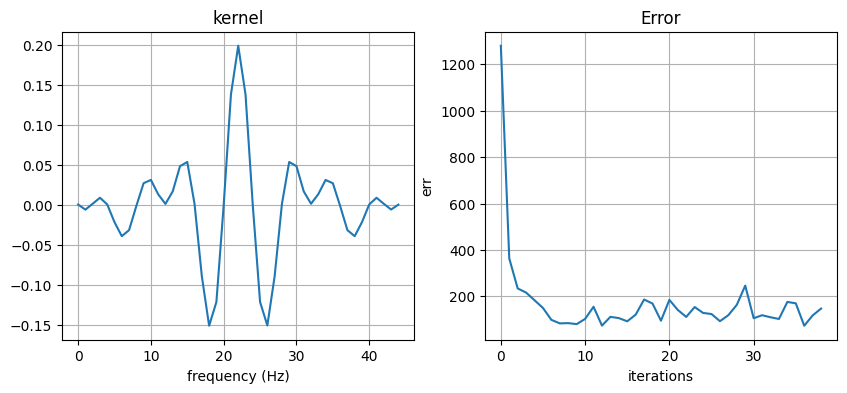

Minumium err: 73.59374237060547


<All keys matched successfully>

In [91]:
for epoch in range(40):
    total=0
    for i in range(10):
        ib,ob = build_batch(t, batch_size)        
        y_pred = model(ib) 
        loss = criterion(y_pred, ob)
        total += loss.detach()/10.0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if total<min_err:
        min_err=total
        best_state = model.state_dict()

    total_list.append(total)

    #plot
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(model.weight[0,0,:].detach().numpy())
    ax1.set(xlabel='frequency (Hz)', ylabel='', title='kernel')        
    ax1.grid()
    if len(total_list)>0:
        ax2.plot(total_list[1:])
        ax2.set(xlabel='iterations', ylabel='err', title='Error')        
        ax2.grid()
    plt.show()    

    scheduler.step()
    print(f'Minumium err: {min_err}')

model.load_state_dict(best_state)

# filter response

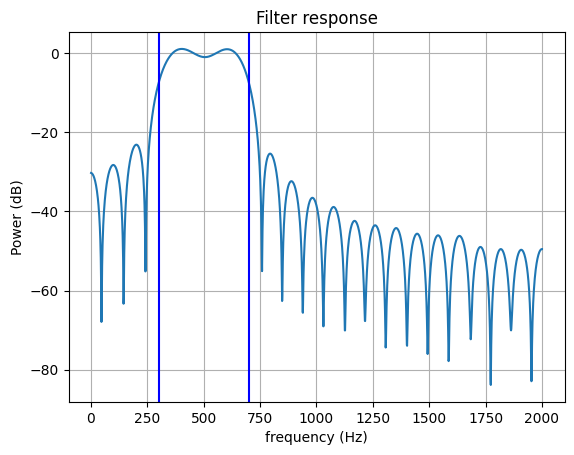

In [97]:
freqs = torch.linspace(1, max_freq, max_freq)
power = torch.zeros_like(freqs)

with torch.no_grad():
       for f in range(freqs.shape[0]):
              x = get_seq(t, freqs[f], 0) * hamming_window         
              y = model(x)
              norm =  torch.sqrt(torch.dot(x[0,0,:],x[0,0,:]))
              power[f] = 10*torch.log(torch.sqrt(torch.dot(y[0,0,:],y[0,0,:]))/norm)


       fig, ax = plt.subplots()
       ax.plot(freqs, power.detach().numpy())
       ax.set(xlabel='frequency (Hz)', ylabel='Power (dB)', title='Filter response')
       plt.axvline(x = cutoff_low, color = 'b')
       plt.axvline(x = cutoff_high, color = 'b')
       ax.grid()
       plt.show()